In [2]:
import numpy as np
import glob
import os
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
#import stagnation.variables as va
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from scipy.optimize import fsolve
import scipy
import time

In [3]:
L = 120 #box size
dx = 120/2**9 #minimum grid size
print(dx)
folderfig='/home/turbots/Documents/final_fig/R0/diss/'
eps = 7.8 #mean dissipation without the bubble
rho  = 1 #fluid density (taken as reference)
sig=dx/2

0.234375


In [4]:
def gaussian(x, sig): #fonction de Gauss utlisé pour la normalisation et le calcul des poids de chaque points
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-1/2*(x/sig)**2)

In [68]:
def expo_decr(x,a,b,cte):
    return np.exp((-1/a)*x+b)+cte

In [6]:
folds = glob.glob('Re*') # we pick up all the files that start with Re and put them in folds
len(folds)# lenght of folds

286

In [7]:
folds0 = 'Re55t140-l9-16-2540-3-dump_86788'
filesdissint = glob.glob(folds0+ '/localstats_[!f]*')
filesdissext = glob.glob(folds0 + '/localstats_fluid*')
filesinterf = glob.glob(folds0 + '/inter*.dat')
        
    

import warnings

with warnings.catch_warnings():#to remove warnings associated to the fact that some files are empty.
    warnings.simplefilter("ignore") 
    dataint = np.zeros([0, 7], dtype=float)
    dataext = np.zeros([0, 6], dtype=float)
    interf = np.zeros([0, 10], dtype=float)
    bubble = np.zeros([0, 12], dtype=float)
    stat = np.zeros([0, 8], dtype=float)
    vit_in = np.zeros([0,17], dtype=float)
    vit_interf = np.zeros([0,17], dtype=float)
    vit_out = np.zeros([0,16], dtype=float)
        


    for file in filesdissint:
        try:
            datatemp = np.loadtxt(file, skiprows=2)
        except:
            datatemp = np.loadtxt(file, skiprows=1)
        if datatemp.shape !=(0,):
            dataint = np.vstack((dataint, datatemp))

    for file in filesinterf:
        datatemp = np.loadtxt(file, skiprows=1)
        if datatemp.shape !=(0,):
            interf = np.vstack((interf, datatemp))

    for file in filesdissext:
        try:
            datatemp = np.loadtxt(file, skiprows=1)
        except:
            datatemp = np.loadtxt(file, skiprows=0)
        if datatemp.shape !=(0,):
            dataext = np.vstack((dataext, datatemp))

try:
    datatemp = np.loadtxt(folds0 +'/bubbles.dat', skiprows=1)
except:
    datatemp = np.loadtxt(folds0 +'/bubbles.dat', skiprows=0)
if datatemp.shape !=(0,):
    bubble = np.vstack((bubble,datatemp))
    
    

In [8]:
R0= float(folds0.split('-')[2])

In [10]:
params = np.zeros(9)

def surf(x, y, z):#equation of the surface
    global params
#     a2, a1, b2, b1, c2, c1, ab, ac, bc, d = params
    a1,b1 ,c1, ab , bc, ac , a2 , b2 , c2 = params
    return a2*x**2 + a1*x + b2*y**2 + b1*y + c2*z**2 + c1*z + ab*x*y + ac*x*z + bc*y*z

def gradient(x, y, z):#gradient of the surface 
    global params
#     a2, a1, b2, b1, c2, c1, ab, ac, bc, d = params
    a1, b1 ,c1, ab , bc, ac , a2 , b2 , c2 = params
    gx = 2*a2*x + a1 + ab*y+ ac*z
    gy = 2*b2*y + b1 + ab*x + bc*z
    gz = 2*c2*z + c1 + ac*x + bc*y
    return np.asarray([gx, gy, gz])

def system(XYZLamb, M):
    '''
    to solve:
    x - xM - lambda gx = 0
    y - yM - lambda gy = 0
    z - zM - lambda gz = 0
    surf(x, y, z) = 0
    
    ie: OM and gradient are colinear and O is on the surface.
    '''
    g = gradient(*XYZLamb[:3])
    p1 = M - XYZLamb[:3] - XYZLamb[3]*g
    p1 = np.append(p1, surf(*XYZLamb[:3]) )
    return p1

In [11]:
# on enlève les petites bulles parasites liées à des problèmes de simulations et qui peuvent fausser les résultats

maskint=(dataint[:,0]>-1)
maskinterf=(interf[:,0]>-1)

print(30*dx)
for bulle in bubble:
    if bulle[3]<30*dx: #la bulle est plus petite que 30 cellules ie pas une "bulle"
        j=bulle[2]
        maskint=np.logical_and(maskint,dataint[:,0][:]!=j)
        maskinterf=np.logical_and(maskinterf,interf[:,0][:]!=j)
print(dataint[:,0].size,maskint.size) 

7.03125
53299 53299


In [12]:
# on calcule approximativement la position du centre de la bulle et on l'utilise pour recentrer les points afin que
#la bulle ne soit pas coupé à travers le domaine. Puis on recalcule le pc (position center)

pc = np.mean(dataint[:, 1:4][maskint], axis=0)# approximate position center
# pc2= np.mean(vit_in[:, 1:4][mask_vit_in], axis=0)
print(pc)
dataint[:, 1:4] = np.mod(dataint[:, 1:4] - pc + L/2, L) - L/2 #shift data position
dataext[:, 0:3] = np.mod(dataext[:, 0:3] - pc + L/2, L) - L/2 #shift data position
interf[:, 1:4] = np.mod(interf[:, 1:4] - pc + L/2, L) - L/2 #shift interface position

pc = np.mean(dataint[:, 1:4], axis=0)# approximate position center
# pc2= np.mean(vit_in[:, 1:4][mask_vit_in], axis=0)
print(pc)

[ 95.9604688  103.82802944  37.44806307]
[1.65105261e-12 2.47999798e-12 1.13133164e-12]


In [24]:
# on masque les points extérieures de la bulle qui sont trop éloigné du centre de la bulle pour réduire le temps 
# de calcul et car on ne s'intéresse qu'a ce qu'il se passe proche de la bulle
maskext=((dataext[:,0]-pc[0])**2+(dataext[:,1]-pc[1])**2+(dataext[:,2]-pc[2])**2<((3*R0)**2)) #5*R0

In [25]:
# on crée un masque pour étudier le problème en 1D et en 2D

z = np.mean(dataint[:, 3][maskint])
dz=0.5
y=np.mean(dataint[:, 2][maskint])
dy=0.5

indicez= np.logical_and(dataint[:, 3]>z-dz, dataint[:, 3]<z+dz )
indicey= np.logical_and(dataint[:, 2]>y-dy, dataint[:, 2]<y+dy )
maskint1d=np.logical_and(indicey,indicez)
maskint2d=np.logical_and(indicez,maskint) #masque 2d pour le champ de données intérieures
maskint1d=np.logical_and(maskint1d,maskint) #masque 1d pour le champ de données intérieures

indicez2= np.logical_and(dataext[:, 2]>z-dz, dataext[:, 2]<z+dz )
indicey2= np.logical_and(dataext[:, 1]>y-dy, dataext[:, 1]<y+dy )
maskext2d=np.logical_and(maskext,indicez2)#masque 2d pour le champ de données extérieures
maskext1d=np.logical_and(indicey2,indicez2)#masque 1d pour le champ de données extérieures
maskext1d=np.logical_and(maskext,maskext1d)

indicez3= np.logical_and(interf[:, 3]>z-dz, interf[:, 3]<z+dz )
indicey3= np.logical_and(interf[:, 2]>y-dy, interf[:, 2]<y+dy )
maskinterf2d=np.logical_and(indicez3,maskinterf)
maskinterf1d=np.logical_and(indicez3,indicey3)
maskinterf1d=np.logical_and(maskinterf,maskinterf1d)

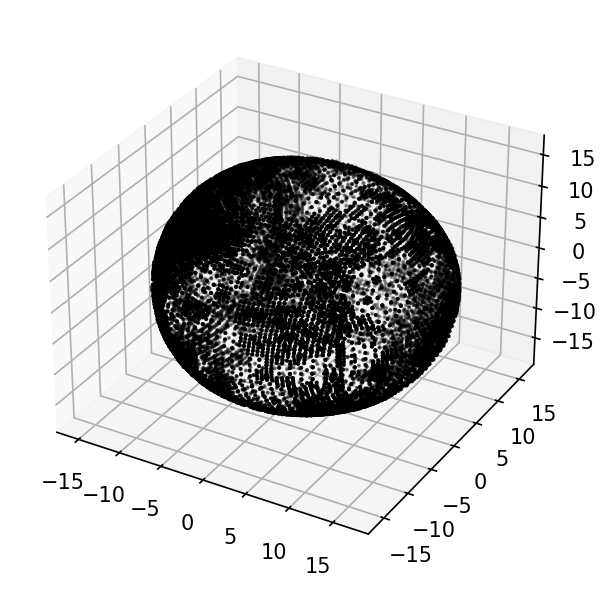

In [26]:
fig = plt.figure(dpi=150)
ax = plt.axes(projection='3d')
#np.mod(X - pc + L/2, L) - L/2
# p2=ax.scatter(dataint[:, 1], dataint[:, 2], dataint[:, 3], c=dataint[:,5], s=1)
ax.scatter(interf[:,1][maskinterf],interf[:,2][maskinterf],interf[:,3][maskinterf],color='k',s=1)
# plt.title('interface of the bubble')
# plt.savefig(folderfig + 'interface_solo_bubble.pdf',bbox_inches='tight')

Text(0.5, 1.0, 'dissipation-1D')

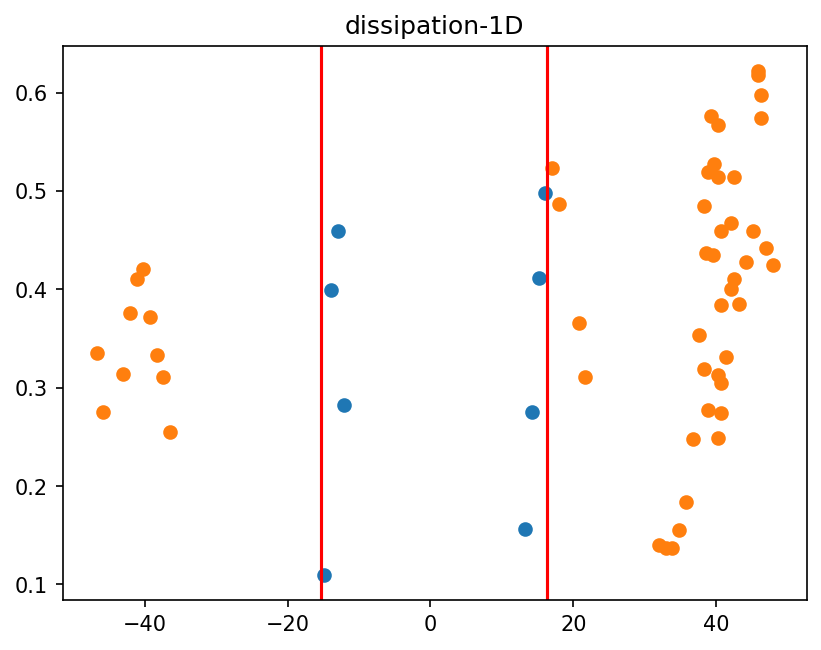

In [29]:
plt.figure(dpi=150)
plt.scatter(dataint[:, 1][maskint1d],dataint[:, 5][maskint1d])
plt.scatter(dataext[:, 0][maskext1d],dataext[:, 4][maskext1d]/25) #on divise par 25=rapport de viscosité air/eau
# délimite la position de la bulle
plt.axvline(min(interf[:,1][maskinterf1d]),color='r')
plt.axvline(max(interf[:,1][maskinterf1d]),color='r') 
plt.title('dissipation-1D')
# plt.xlim(-20,20)

In [30]:
voronoi_kdtree = cKDTree(interf[:, 1:4]) #fonction qui trace un diagramme de Voronoi. 
#Ce diagrame permet de crée des régions où sont regorupés tout les points les points proches 
#d'un point de l'interface. Ça permet de calculer la distance des points à l'interface

In [31]:
# On récupère l'indice des points de l'interface les plus proches pour chaque point de l'écoulement
test_point_dist_ext, regions_ext = voronoi_kdtree.query(dataext[:, 0:3][maskext])
test_point_dist_int, regions_int = voronoi_kdtree.query(dataint[:, 1:4][maskint])

In [32]:
def interpolate_surf(interface_points):
#     calcule des coefficients d'interpolation de la surf pour tous les points de l'interface
    surface = {}
    for i , element in enumerate(interface_points):
        (distances,voisins) = voronoi_kdtree.query(element,k=20)
        vois = interface_points[voisins,:]
        A = np.c_[vois[:,:], vois[:,0]*vois[:,1],vois[:,2]*vois[:,1],vois[:,0]*vois[:,2], vois[:,:]**2]
        params,_,_,_ = scipy.linalg.lstsq(A, np.ones(vois.shape))
        params = params[:,0]
        surface[i] = params
    return surface

In [33]:
def compute_distance(points, interface_points, regions, surface):
# calcule de la distance à l'interface pour tous les points mis en arguments dans 'points'
    distance =  np.zeros(len(points))
    for i , element in enumerate(points):
        indice_interface = regions[i]
        interf = interface_points[indice_interface]
        params = surface[indice_interface]
        out = fsolve(system, np.append(interf+1,1), args=(element), full_output=True)
        sol = out[0]
        normale = sol[:3]/np.linalg.norm(sol[:3])
        n_voronoi = element - interf
        distance[i] = np.sum(normale*n_voronoi)
    return distance


In [34]:
tps1 = time.time()
surface = interpolate_surf(interf[:,1:4][maskinterf])
distance_ext = compute_distance(dataext[maskext][:,:3],interf[:,1:4][maskinterf],regions_ext,surface)
distance_int = compute_distance(dataint[maskint][:,1:4],interf[:,1:4][maskinterf],regions_int,surface)
tps2 = time.time()
print(tps2-tps1)

76.31757307052612


In [47]:
dist_ext = np.linspace(0, 2*R0, 500) # grille d'interpolation à l'exterieur de la bulle
dist_int = np.linspace(0, R0, 100) # grille d'interpolation à l'interieur de la bulle

In [48]:
#test de la normalisation avec une fonction exponentielle

weights = gaussian( distance_ext -dist_ext[:, np.newaxis], sig)
expo=np.exp(distance_ext)
mean = np.sum(expo*weights*dataext[:, 5][maskext], axis=1)/np.sum(dataext[:, 5][maskext]*weights, axis=1)

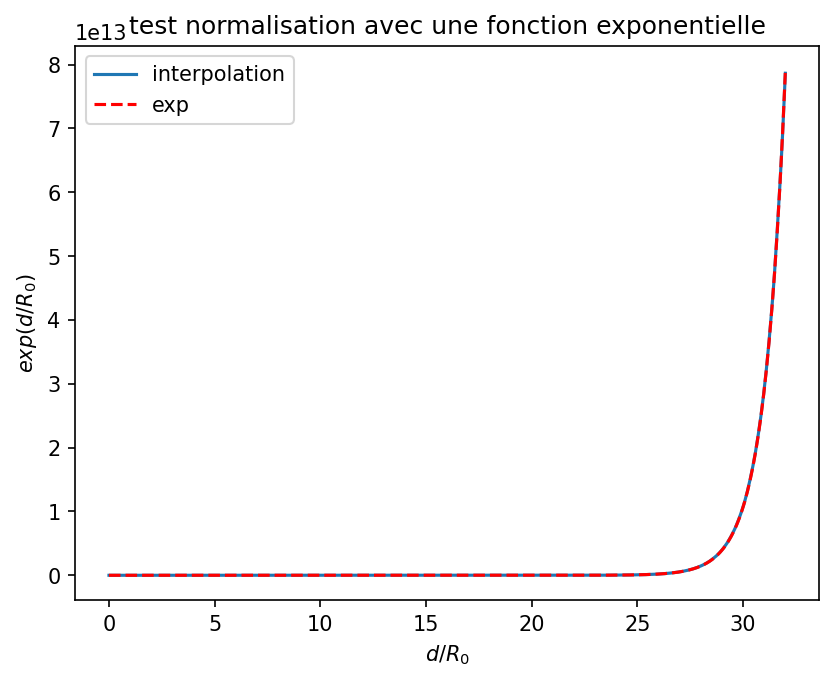

In [49]:
plt.figure(dpi=150)
plt.plot(dist_ext,mean, label = 'interpolation')
plt.xlabel('$d/R_0$')
plt.ylabel('$exp(d/R_0)$')
plt.plot(dist_ext,np.exp(dist_ext),color='r',linestyle='--',label = 'exp')
plt.title('test normalisation avec une fonction exponentielle')
plt.legend()

In [50]:
# dissipation outside
weights = gaussian(distance_ext -dist_ext[:, np.newaxis], sig)
#mean dissipation
meandiss_ext = np.sum(dataext[:, 4][maskext]*weights*dataext[:, 5][maskext], axis=1)/np.sum(dataext[:, 5][maskext]*weights,axis=1)

In [51]:
weights = gaussian(distance_int -dist_int[:, np.newaxis], sig)
#mean dissipation
meandiss_int = np.sum(dataint[:, 5][maskint]*weights*dataint[maskint][:, -1], axis=1)/np.sum(dataint[maskint][:, -1]*weights,axis=1)

/tmp/ipykernel_859813/715332148.py:3: RuntimeWarning: invalid value encountered in divide
  meandiss_int = np.sum(dataint[:, 5][maskint]*weights*dataint[maskint][:, -1], axis=1)/np.sum(dataint[maskint][:, -1]*weights,axis=1)


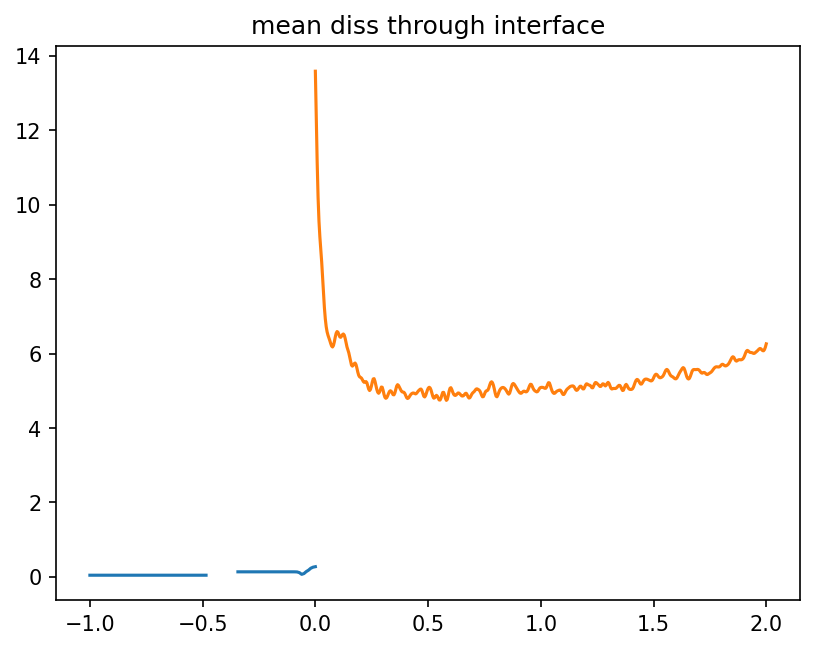

In [52]:
plt.figure(dpi=150)
plt.title('mean diss through interface')
plt.plot(dist_int*(-1)/R0, meandiss_int)
plt.plot(dist_ext/R0,meandiss_ext)
# plt.xlim(-0.5,0.5)
# plt.savefig(folderfig + 'dissipation_interface.single_simu.pdf',bbox_inches='tight')

In [43]:
def loadfiles(filename):
    '''
    Load local_stats, localstats_fluid and interface files knowing the folder direction. 
    Return datain, dataout & interf
    '''
    import warnings

    with warnings.catch_warnings():#to remove warnings associated to the fact that some files are empty.
        warnings.simplefilter("ignore")    
        filesdissint = glob.glob(filename + '/localstats_[!f]*')
        filesdissext = glob.glob(filename + '/localstats_fl*')
        filesinterf = glob.glob(filename + '/inter*.dat')
#         filestat = glob.glob(filename + '/stats.dat')

        data1 = np.zeros([0, 7], dtype=float)
        data2 = np.zeros([0, 6], dtype=float)
        interf = np.zeros([0, 10], dtype=float)
        stat = np.zeros([0,8], dtype=float)
        bubble = np.zeros([0,12], dtype=float)
        

        with open(filename + '/stats.dat', 'r') as f:
            stat=[]
            for line in f:
                if "t" in line:
    #         si on lit "t", on saute la ligne, ie on saute la 1er ligne
                    continue
                data=line.split()
                for i in np.arange(len(data)):
                    temp=float(data[i])
                    stat.append(temp)

    

        for file in filesdissint:
            try:
                datatemp = np.loadtxt(file, skiprows=2)
            except:
                datatemp = np.loadtxt(file, skiprows=1)
            if datatemp.shape !=(0,):
                data1 = np.vstack((data1, datatemp))

        for file in filesinterf:
            datatemp = np.loadtxt(file, skiprows=1)
            if datatemp.shape !=(0,):
                interf = np.vstack((interf, datatemp))
                
        for file in filesdissext:
            try:
                datatemp = np.loadtxt(file, skiprows=1)
            except:
                datatemp = np.loadtxt(file, skiprows=0)
            if datatemp.shape !=(0,):
                data2 = np.vstack((data2, datatemp))
        
        datatemp=np.loadtxt(filename + '/bubbles.dat',skiprows=1)
        if datatemp.shape !=(0,):
                bubble = np.vstack((bubble,datatemp))



        return data1, data2, interf, stat, bubble

In [56]:
t1 = time.time()
dist_int = np.linspace(0, 8, 100)  
dico_donnees={}
dissipationint = {}
kineticint = {}
dissipationext = {}
kineticext = {}
occ_R0_dump={}

for fold in folds:
    R0 = float(fold.split('-')[2])
    dist_ext = np.linspace(0,1.5*R0)
    datain,dataout, interf, stat, bubble = loadfiles(fold);
    #test whether the bubble broke or not. If so there are several bubbles and so 
    # bubble number can be larger than 0. 
    print(fold)
    if 1 in datain[:, 0]:
        print('break')
        print(np.max(datain[:, 0]))
        continue
    

    #recenter
    pc = np.median(datain[:, 1:4], axis=0)

#     point intérieurs
    maskint=(datain[:,0]>-1)
    maskinterf=(interf[:,0]>-1)
#     print(bubble)
    for bulle in bubble:
        if bulle[3]<30*dx: #la bulle est plus petite que 30 cellules ie pas une "bulle"
            j=bulle[2]
            maskint=np.logical_and(maskint,datain[:,0][:]!=j)
            maskinterf=np.logical_and(maskinterf,interf[:,0][:]!=j)
    
#   compute the interpolation surface coefficients for all interface points

    
    # on recentre les points
    datain[:, 1:4] = np.mod(datain[:, 1:4][maskint] - pc + L/2, L) - L/2
    interf[:, 1:4] = np.mod(interf[:, 1:4][maskinterf] - pc + L/2, L) - L/2
    #compute distance
    #Voronoi diagram
    voronoi_kdtree = cKDTree(interf[:,1:4][maskinterf])
    surface = interpolate_surf(interf[maskinterf][:,1:4])
    #Region of the test points
    test_point_dist, regions_int = voronoi_kdtree.query(datain[:,1:4][maskint])
#     positif=(np.sum((datain[:,1:4][maskint]-interf[:,1:4][regions_int])*normale, axis=1)>=0)
#     maskint=np.logical_and(maskint,positif)
    #distance with scalar product with the normal
    
    distance_int = compute_distance(datain[:,1:4],interf[maskinterf][:,1:4],regions_int,surface)
   
    


    #compute avg
#     sig = np.min(data[:, -1])**(1/3)/2
    weights = gaussian(distance_int -dist_int[:, np.newaxis], sig)
    norm = np.sum(datain[:, 6][maskint]*weights, axis=1)
    meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
    meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy
    


    if R0 not in dissipationint:
        dissipationint[R0] = np.zeros([3, len(dist_int)])
        kineticint[R0] = np.zeros([3, len(dist_int)])
        occ_R0_dump[R0] = 0
        

    ind = dist_int<np.max(test_point_dist)
    dissipationint[R0][0, :][ind] += meandiss[ind]#avg
    dissipationint[R0][1, :][ind] += meandiss[ind]**2 #std
    dissipationint[R0][2, :][ind] += 1#nbr

    kineticint[R0][2, :][ind] += 1
    kineticint[R0][0, :][ind] += meankin[ind]
    kineticint[R0][1, :][ind] += meankin[ind]**2  
    
    occ_R0_dump[R0] +=1
    
    with open( fold +  '/dissint.pkl', 'wb') as f:
        pickle.dump(dissipationint, f)

#     points extérieurs

    dataout[:, 0:3] = np.mod(dataout[:, 0:3] - pc + L/2, L) - L/2
    pc=np.mean(datain[:,1:4], axis=0)
    index =((dataout[:,0]-pc[0])**2+(dataout[:,1]-pc[1])**2+(dataout[:,2]-pc[2])**2<((3*R0)**2)) #3*R0
    
    #compute distance
    test_point_dist, regions_ext = voronoi_kdtree.query(dataout[:,0:3][index])
    distance_ext = compute_distance(dataout[:,:3][index],interf[maskinterf][:,1:4],regions_ext,surface)



    #compute avg
    weights = gaussian(distance_ext -dist_ext[:, np.newaxis], sig)
    norm = np.sum(dataout[:, 5][index]*weights, axis=1)
    meandiss = np.sum(dataout[:,4][index]*weights*dataout[:, 5][index], axis=1)/norm
    meankin = np.sum(dataout[:,3][index]*weights*dataout[:, 5][index], axis=1)/norm
    
   
    
    if R0 not in dissipationext:
        dissipationext[R0] = np.zeros([3, len(dist_ext)])
        kineticext[R0] = np.zeros([3, len(dist_ext)])


    ind = dist_ext<np.max(test_point_dist) #
    dissipationext[R0][0, :][ind] += meandiss[ind]#avg
    dissipationext[R0][1, :][ind] += meandiss[ind]**2 #std
    dissipationext[R0][2, :][ind] += 1#nbr

    kineticext[R0][2, :][ind] += 1
    kineticext[R0][0, :][ind] += meankin[ind]
    kineticext[R0][1, :][ind] += meankin[ind]**2
        
    with open( fold +  '/dissext.pkl', 'wb') as f:
        pickle.dump(dissipationext, f)

    
for tab in [dissipationint, kineticint]:
    for key in tab:
        tab[key][0, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1) #on divise par le nombre d'occurence pour moyenné
        tab[key][1, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
        tab[key][1, :] -= tab[key][0, :]**2
        tab[key][1, :] = np.sqrt(tab[key][1, :])

for tab in [dissipationext, kineticext]:
    for key in tab:
        tab[key][0, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
        tab[key][1, :] /= np.where(tab[key][2, :]>0, tab[key][2, :], 1)
        tab[key][1, :] -= tab[key][0, :]**2
        tab[key][1, :] = np.sqrt(tab[key][1, :])
t2 = time.time()
print(t2-t1)

Re55t140-l9-16-2540-2-dump_63405
Re55t140-l9-8-2240-2-dump_83039
Re55t140-l9-8-2240-dump_51678


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-12-1572-2-dump_55336
Re55t140-l9-12-1572-dump_29055
Re55t140-l9-8-3000-4-dump_142890
Re55t140-l9-8-2240-2-dump_57959
Re55t140-l9-8-800-dump_46791


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-3-dump_84292
Re55t140-l9-8-2240-4-dump_120681
Re55t140-l9-12-1572-3-dump_94752
Re55t140-l9-8-2240-4-dump_114411
Re55t140-l9-8-2240-2-dump_76769
Re55t140-l9-16-2540-dump_33343
Re55t120-l9-8-400-dump_40409


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-2-dump_79904
Re55t140-l9-12-1572-3-dump_102633
Re55t140-l9-12-1572-3-dump_113141
Re55t120-l9-8-400-dump_41734
Re55t140-l9-8-2240-4-dump_123816
Re55t140-l9-8-3000-3-dump_99344


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-2-dump_54817
Re55t140-l9-12-1572-dump_1
Re55t120-l9-8-400-dump_36425


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-4-dump_132006


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-dump_1
Re55t140-l9-16-2540-dump_26665
Re55t120-l9-8-400-2-dump_48441
Re55t140-l9-8-2240-dump_45408


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-3-dump_98725


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-dump_29733
Re55t140-l9-8-560-dump_26075


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-dump_37051


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-2-dump_60066
Re55t140-l9-16-2540-dump_30004


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t120-l9-8-400-dump_35100
Re55t120-l9-8-400-2-dump_67085


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-12-1572-3-dump_107887
Re55t140-l9-8-560-2-dump_54309
Re55t140-l9-8-800-dump_0
Re55t140-l9-16-2540-2-dump_73422
Re55t120-l9-8-400-2-dump_57762
Re55t140-l9-8-2240-2-dump_67364
Re55t120-l9-8-400-dump_44392
Re55t140-l9-8-800-2-dump_71163
Re55t140-l9-8-3000-3-dump_95716
Re55t120-l9-8-400-dump_39084
Re55t140-l9-12-1572-2-dump_81606
Re55t120-l9-8-400-2-dump_64435


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-2-dump_76269


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-4-dump_130206
Re55t120-l9-8-400-2-dump_59087
Re55t120-l9-8-400-2-dump_55112


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-4-dump_117546


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-2-dump_73634


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t120-l9-8-400-dump_37759


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-2-dump_73037
Re55t140-l9-8-800-dump_33673
Re55t140-l9-8-800-2-dump_63667
Re55t140-l9-16-2540-4-dump_123528
Re55t140-l9-8-2240-4-dump_0


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-dump_1
Re55t140-l9-16-2540-5-dump_0
Re55t140-l9-8-3000-dump_30390


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-2-dump_71565
Re55t120-l9-8-400-2-dump_60455


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-2-dump_74701
Re55t140-l9-12-1572-2-dump_84233
Re55t140-l9-16-2540-3-dump_83449


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-2-dump_69997
Re55t140-l9-8-2240-3-dump_89320


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-2-dump_76785
Re55t140-l9-16-2540-2-dump_1
Re55t140-l9-8-3000-2-dump_63053


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-2-dump_1


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-2-dump_61094
Re55t120-l9-8-400-2-dump_52462
Re55t140-l9-12-1572-3-dump_97379
Re55t140-l9-12-1572-2-dump_60590
Re55t140-l9-8-3000-4-dump_121122
Re55t140-l9-16-2540-2-dump_56727
Re55t140-l9-8-800-3-dump_0
Re55t140-l9-16-2540-3-dump_103483
Re55t140-l9-8-560-dump_40187
Re55t140-l9-16-2540-3-dump_1
Re55t140-l9-16-2540-4-dump_1
Re55t120-l9-8-400-2-dump_56437
Re55t140-l9-8-2240-2-dump_0
Re55t140-l9-12-1572-2-dump_78979
Re55t120-l9-8-400-2-dump_49793


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-4-dump_116850
Re55t140-l9-16-2540-4-dump_126867
Re55t140-l9-8-800-dump_50539


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-12-1572-dump_34309


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-2-dump_59425
Re55t140-l9-8-560-2-dump_63725
Re55t140-l9-8-800-2-dump_1


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-2-dump_1
Re55t140-l9-8-3000-dump_41274
Re55t140-l9-16-2540-3-dump_96805
Re55t120-l9-8-400-dump_47090
Re55t140-l9-12-1572-2-dump_68471


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-3-dump_102972


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-2-dump_74911


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-2-dump_66861
Re55t140-l9-8-560-2-dump_57445
Re55t140-l9-12-1572-dump_0
Re55t140-l9-12-1572-2-dump_76352


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-4-dump_0
Re55t140-l9-8-3000-3-dump_92088


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-3-dump_1


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-12-1572-2-dump_1
Re55t140-l9-8-3000-2-dump_70309


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-4-dump_1
Re55t140-l9-16-2540-3-dump_80110
Re55t140-l9-8-2240-dump_32868
Re55t140-l9-8-560-dump_41755
Re55t140-l9-16-2540-2-dump_0
Re55t140-l9-8-560-dump_29211


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-3-dump_86185


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-2-dump_55797


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t120-l9-8-400-2-dump_65760
Re55t140-l9-8-800-dump_1
Re55t140-l9-8-3000-2-dump_1
Re55t140-l9-8-800-2-dump_69289
Re55t140-l9-8-560-2-dump_77837
Re55t140-l9-16-2540-2-dump_66744
Re55t140-l9-16-2540-dump_40021
Re55t140-l9-8-560-dump_48027


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-12-1572-dump_42190
Re55t140-l9-8-2240-dump_36003


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-12-1572-3-dump_105260


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-dump_42273
Re55t140-l9-8-2240-3-dump_0
Re55t140-l9-8-3000-dump_48530
Re55t140-l9-8-2240-dump_0
Re55t140-l9-12-1572-2-dump_65844
Re55t140-l9-12-1572-2-dump_73725


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t120-l9-8-400-dump_24350
Re55t120-l9-8-400-dump_27098
Re55t140-l9-12-1572-2-dump_63217
Re55t140-l9-8-3000-dump_0
Re55t140-l9-8-2240-2-dump_70499


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-dump_35547
Re55t140-l9-8-3000-dump_26762
Re55t140-l9-8-560-2-dump_55877


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-dump_33915
Re55t140-l9-16-2540-4-dump_110172
Re55t140-l9-8-800-2-dump_65541
Re55t140-l9-8-3000-3-dump_84832
Re55t140-l9-16-2540-4-dump_113511
Re55t120-l9-8-400-dump_0


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-2-dump_62157
Re55t140-l9-8-560-dump_30779
Re55t140-l9-16-2540-2-dump_76761
Re55t140-l9-12-1572-3-dump_110514


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-3-dump_108130


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-2-dump_59919


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-5-dump_1
Re55t120-l9-8-400-2-dump_61780
Re55t140-l9-16-2540-dump_46699
Re55t120-l9-8-400-dump_45765


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-3-dump_1
Re55t140-l9-8-800-2-dump_0


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t120-l9-8-400-dump_25693
Re55t140-l9-8-3000-2-dump_73937
Re55t140-l9-8-3000-3-dump_88460


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-2-dump_66681


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-dump_41169
Re55t140-l9-16-2540-3-dump_0
Re55t140-l9-8-3000-dump_34018
Re55t140-l9-8-800-2-dump_67415
Re55t120-l9-8-400-dump_28423


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-3-dump_90127
Re55t140-l9-8-3000-dump_52158
Re55t140-l9-12-1572-dump_52698
Re55t140-l9-8-800-dump_37421
Re55t140-l9-8-560-dump_0
Re55t140-l9-8-2240-dump_48543
Re55t140-l9-8-3000-3-dump_106600


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-4-dump_139262


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-4-dump_1


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-4-dump_124750
Re55t140-l9-8-800-dump_26177


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-5-dump_1
Re55t140-l9-8-2240-4-dump_111276
Re55t120-l9-8-400-2-dump_1
Re55t140-l9-8-800-3-dump_1
Re55t140-l9-12-1572-3-dump_89498
Re55t140-l9-12-1572-dump_47444
Re55t140-l9-12-1572-dump_31682
Re55t140-l9-16-2540-3-dump_106822
Re55t140-l9-8-560-dump_38619


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-2-dump_70083


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t120-l9-8-400-dump_29748


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-4-dump_133545
Re55t140-l9-12-1572-2-dump_0
Re55t140-l9-8-2240-dump_54813
Re55t140-l9-8-560-dump_43323


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-2-dump_60589


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t120-l9-8-400-2-dump_63110
Re55t140-l9-16-2540-3-dump_100144


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-dump_56161
Re55t140-l9-12-1572-dump_26428
Re55t140-l9-8-560-dump_27643
Re55t140-l9-8-800-dump_44917
Re55t140-l9-8-800-2-dump_80533
Re55t140-l9-8-560-2-dump_65293
Re55t140-l9-8-3000-2-dump_81193
Re55t140-l9-8-2240-3-dump_101860


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t120-l9-8-400-dump_43067


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-dump_39295
Re55t120-l9-8-400-dump_32450
Re55t140-l9-8-3000-dump_37646
Re55t140-l9-12-1572-3-dump_86871
Re55t140-l9-12-1572-3-dump_1
Re55t140-l9-12-1572-3-dump_0
Re55t140-l9-12-1572-dump_50071
Re55t120-l9-8-400-2-dump_51118


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-dump_52413


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-2-dump_53388
Re55t140-l9-8-560-dump_1
Re55t140-l9-16-2540-3-dump_93466
Re55t120-l9-8-400-dump_31073


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-12-1572-2-dump_71098


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-3-dump_95590


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-4-dump_128378
Re55t140-l9-8-3000-4-dump_0
Re55t140-l9-12-1572-3-dump_92125
Re55t140-l9-8-2240-3-dump_92455
Re55t140-l9-8-560-dump_49595


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-3-dump_86166
Re55t140-l9-12-1572-dump_36936
Re55t140-l9-8-800-dump_31799
Re55t140-l9-8-800-dump_43043
Re55t140-l9-8-800-2-dump_82407
Re55t140-l9-16-2540-4-dump_120189
Re55t140-l9-8-800-2-dump_61793
Re55t140-l9-8-560-2-dump_59013
Re55t140-l9-16-2540-dump_0
Re55t140-l9-8-800-dump_48665


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-5-dump_136894
Re55t140-l9-8-3000-dump_1
Re55t140-l9-8-560-dump_52731


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-3-dump_0


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-3-dump_104995


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-2-dump_58045


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-2-dump_77565
Re55t140-l9-8-560-dump_44891
Re55t140-l9-8-800-2-dump_78659


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-800-dump_28051
Re55t140-l9-12-1572-dump_44817
Re55t140-l9-12-1572-dump_39563
Re55t140-l9-8-3000-4-dump_117494
Re55t140-l9-8-800-3-dump_88040
Re55t140-l9-8-560-2-dump_0
Re55t120-l9-8-400-dump_1


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-4-dump_135634


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-dump_43360
Re55t140-l9-8-3000-5-dump_146528
Re55t140-l9-8-3000-3-dump_113856


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t120-l9-8-400-2-dump_0
Re55t140-l9-8-3000-5-dump_0
Re55t140-l9-8-560-dump_51163


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-2-dump_73133


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-dump_26598
Re55t140-l9-8-2240-dump_39138


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-dump_50038
Re55t140-l9-12-1572-2-dump_57963
Re55t120-l9-8-400-dump_33775
Re55t140-l9-8-2240-4-dump_130086


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-3-dump_110228
Re55t140-l9-8-3000-2-dump_0
Re55t140-l9-8-2240-2-dump_64229
Re55t140-l9-16-2540-dump_36682
Re55t140-l9-8-560-dump_46459


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-3000-dump_44902


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-2240-4-dump_126951


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-16-2540-3-dump_86788
Re55t120-l9-8-400-2-dump_53787


/tmp/ipykernel_859813/1714096410.py:61: RuntimeWarning: invalid value encountered in divide
  meandiss = np.sum(datain[:, 5][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean dissip
/tmp/ipykernel_859813/1714096410.py:62: RuntimeWarning: invalid value encountered in divide
  meankin = np.sum(datain[:, 4][maskint]*weights*datain[:, 6][maskint], axis=1)/norm #mean kinetic energy


Re55t140-l9-8-560-dump_35483
Re55t140-l9-8-560-2-dump_68429
Re55t140-l9-12-1572-3-dump_100006
Re55t140-l9-8-800-dump_54287
Re55t140-l9-8-560-dump_32347
Re55t140-l9-8-800-dump_29925
10016.125217676163


In [58]:
lr0 = []
for key in dissipationint:
    lr0.append(key)
lr0 = np.sort(lr0)
print(lr0)

#on verifie que les we sont bien égaux pour les  tailles de bulles
we1=(2*rho*eps**(2/3)*(2*8)**(5/3)/800)
we2=(2*rho*eps**(2/3)*(2*12)**(5/3)/1572)
we3=(2*rho*eps**(2/3)*(2*16)**(5/3)/2540)
print(we1,we2,we3)

[ 8. 12. 16.]
0.9989330486864284 0.9992157216548909 0.9988707857200864


In [79]:
occ_R0_dump

{16.0: 44, 8.0: 202, 12.0: 40}

/tmp/ipykernel_859813/3800200928.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


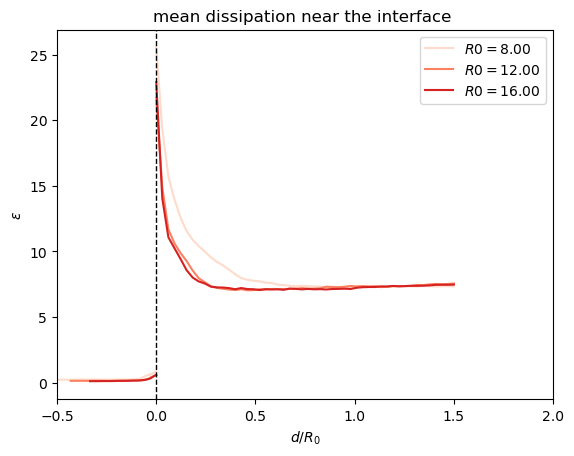

In [121]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lr0:
    if key<700:
        pass
    dist_ext = np.linspace(0,1.5*key)
    line, = plt.plot(dist_ext/key, dissipationext[key][0,:],color=cmap(i+1),label = f'$R0 = {key:.2f}$')
    line, = plt.plot(dist_int*(-1)/key, dissipationint[key][0,:],color=cmap(i+1))
    i+=2
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$\epsilon$')
plt.xlim(-.5,2)
plt.axvline(0,color='k',linestyle='--',lw=1)
plt.title('mean dissipation near the interface ')
plt.savefig(folderfig + 'mean_dissipation_for_diff_sizes.pdf',bbox_inches='tight')

/tmp/ipykernel_859813/2266907425.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


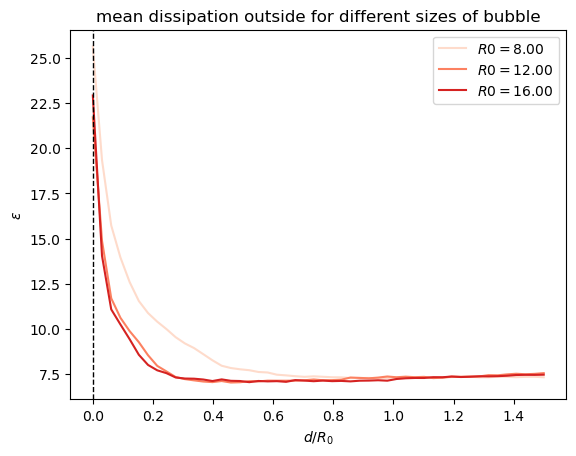

In [122]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
opti = {}
err = {}
for key in lr0:
    if key<700:
        pass
    dist_ext = np.linspace(0,1.5*key)
    line, = plt.plot(dist_ext/key, dissipationext[key][0,:],color=cmap(i+1),label = f'$R0 = {key:.2f}$')
    popt, pcov = curve_fit(expo_decr,dist_ext/key, dissipationext[key][0,:])
    opti[key] = popt
    err[key] = np.sqrt(np.diag(pcov))
    i+=2
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$\epsilon$')

plt.axvline(0,color='k',linestyle='--',lw=1)
plt.title('mean dissipation outside for different sizes of bubble')
plt.savefig(folderfig + 'mean_dissipation_R0_out.pdf',bbox_inches='tight')

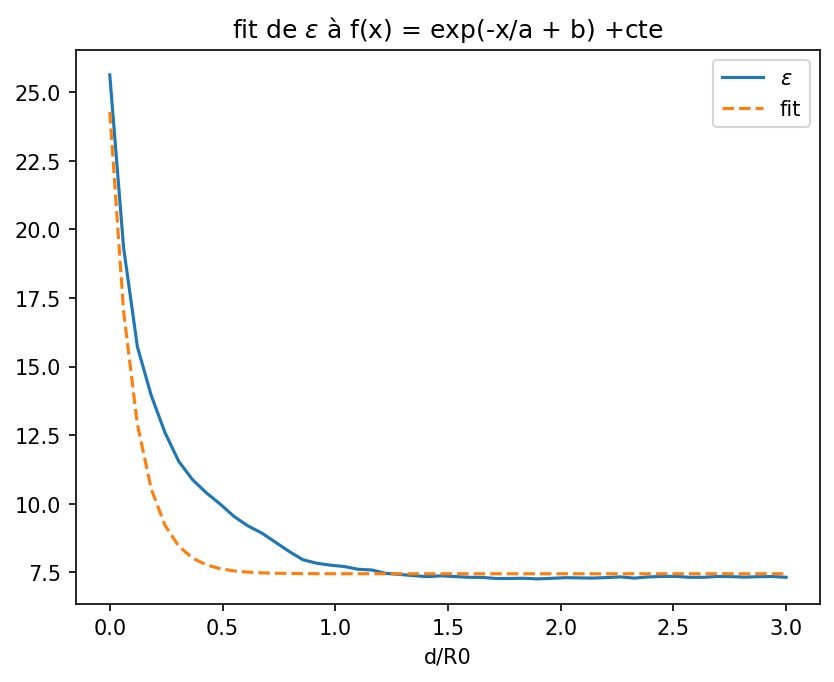

In [130]:
plt.figure(dpi = 150)
key = 8
plt.plot(dist_ext/key, dissipationext[key][0,:], label='$\epsilon$')
plt.plot(dist_ext/R0, expo_decr(dist_ext/R0, opti[key][0], opti[key][1], opti[key][2]), linestyle='--', label='fit')
plt.legend()
plt.xlabel('d/R0')
plt.title('fit de $\epsilon$ à f(x) = exp(-x/a + b) +cte')
plt.savefig(folderfig + 'fit-exp-epsilon.pdf', bbox_inches = 'tight')

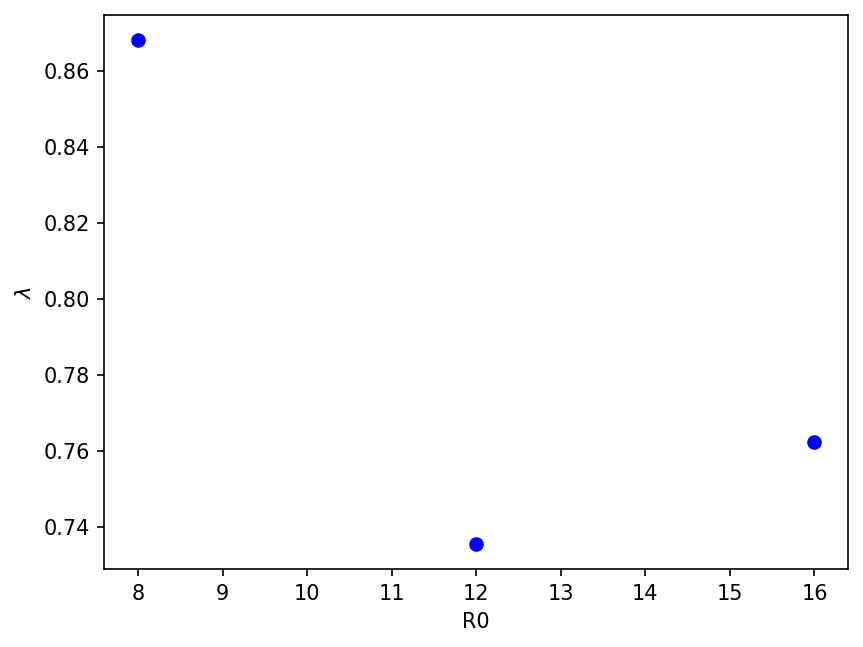

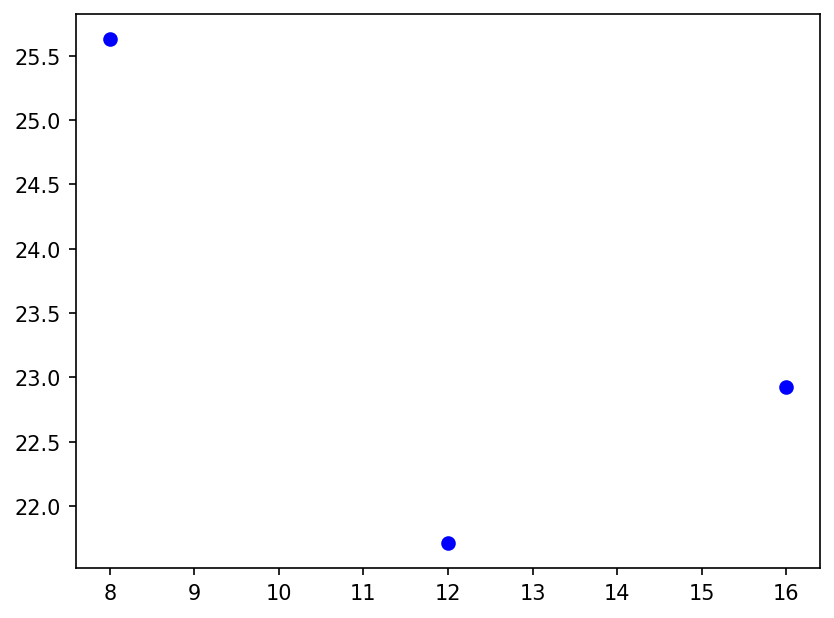

In [139]:
plt.figure(dpi=150)
for key in lr0:
    plt.scatter(key, opti[key][0]*key, color = 'b')
plt.xlabel('R0')
plt.ylabel('$\lambda$')
    
plt.figure(dpi = 150)
for key in lr0:
    plt.scatter(key ,dissipationext[key][0,0], color='b')


/tmp/ipykernel_859813/2606026819.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 8)


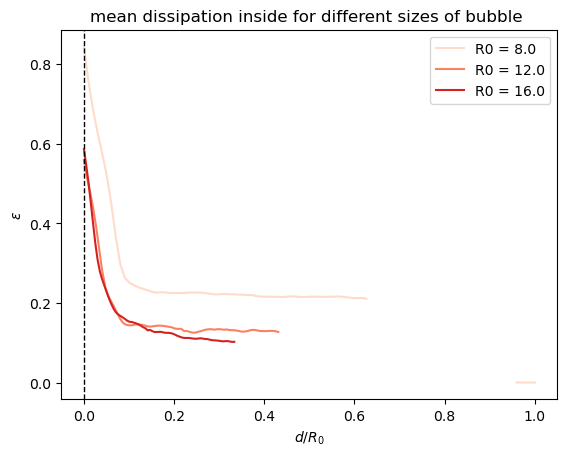

In [140]:
cmap = plt.cm.get_cmap('Reds', 8)
i=0
for key in lr0:
    if key<700:
        pass
    dist_ext = np.linspace(0,1.5*key)

    line, = plt.plot(dist_int/key, dissipationint[key][0,:],color=cmap(i+1), label = f'R0 = {key}')
    i+=2
plt.legend()
plt.xlabel(r'$d/R_0$')
plt.ylabel(r'$\epsilon$')

plt.axvline(0,color='k',linestyle='--',lw=1)
plt.title('mean dissipation inside for different sizes of bubble ')
plt.savefig(folderfig + 'mean_dissipation_for_diff_sizes.pdf',bbox_inches='tight')

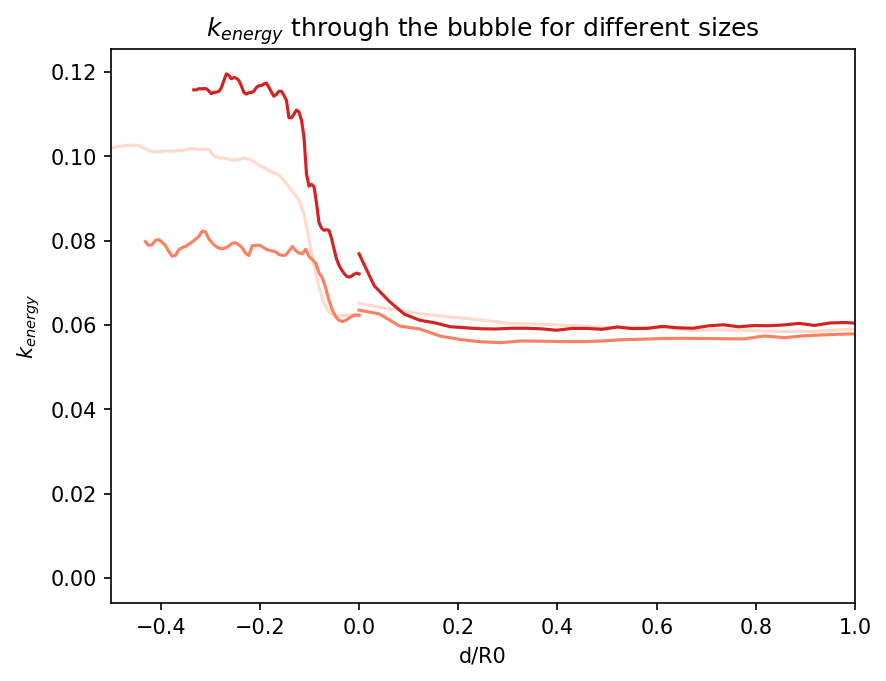

In [129]:
plt.figure(dpi = 150)
i=0
for key in lr0:
    
    plt.plot(dist_ext/key, kineticext[key][0,:]/850, color = cmap(i+1), label = f'we = {key}')
    plt.plot(dist_int*(-1)/key, kineticint[key][0,:], color = cmap(i+1))
    i+=2
plt.xlim(-.5,1)
plt.xlabel('d/R0')
plt.ylabel('$k_{energy}$')
plt.title('$k_{energy}$ through the bubble for different sizes')
plt.savefig(folderfig + 'kenergy-R0.pdf', bbox_inches = 'tight')